In [1]:
#data source: 
#https://cse.hkust.edu.hk/scrg/

import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function that return a list of files to read in a given folder
def get_files(direc):
    full_files = []
    for root, dirs, files in os.walk(direc):
        for name in files:
            full_files.append(os.path.join(root, name))
        
    return full_files

In [2]:
full_files = get_files('D:/study_by_YYC/study_2021_10/Taxi_HKUST/taxi/')           # All folders: 700 MB


data = []
for index, file_path in enumerate(full_files):
    data.append(pd.read_csv(file_path, infer_datetime_format=True,\
            header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude','speed','angle','status']))

data = pd.concat(data, ignore_index=True)

print("Size of data frame: ", data.shape)
print("%.1f million rows" % (data.shape[0]/1.0e6))

# Drop duplicates and NAs 
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

Size of data frame:  (6075587, 7)
6.1 million rows


In [3]:
#保存文件
data.to_csv("D:/study_by_YYC/study_2021_10/Taxi_HKUST/data.csv")

In [4]:
data=pd.read_csv("D:/study_by_YYC/study_2021_10/Taxi_HKUST/data.csv")
data.head()

,Unnamed: 0,taxi_id,date_time,longitude,latitude,speed,angle,status
0,0,10001,2007-02-20 00:02:27,121.423167,31.165233,7,116,3
1,1,10001,2007-02-20 00:05:36,121.423167,31.165233,7,116,3
2,2,10001,2007-02-20 00:08:45,121.423167,31.165233,7,116,3
3,3,10001,2007-02-20 00:11:55,121.423167,31.165233,7,116,3
4,4,10001,2007-02-20 00:15:04,121.423167,31.165233,7,116,3


In [5]:
# 删除data中status处于非0，1的数据，0表示当前空车，1表示当前搭载了乘客
data = data.drop(data[data.status>1].index)
data = data.drop('speed',axis=1)
data = data.drop('angle',axis=1)
data.head()

,Unnamed: 0,taxi_id,date_time,longitude,latitude,status
2117,2117,10004,2007-02-20 00:02:27,121.414583,31.16,1
2118,2118,10004,2007-02-20 00:08:45,121.414583,31.16,1
2119,2119,10004,2007-02-20 00:11:55,121.414583,31.16,1
2120,2120,10004,2007-02-20 00:18:13,121.414583,31.16,1
2121,2121,10004,2007-02-20 00:24:31,121.414583,31.16,1


In [6]:
#提取GPS轨迹的OD点，由0变为1为O，1变为0为D
#每一行的“载客状态”，减去上一行或者下一行。所以需要对这一列数据整体进行一个向上或向下平移，生成一个新列，然后做一个两列相减。然后，要删除掉对后续数据分析无意义的列，减少数据量。
data['status_1']=data['status'].shift(1)
data['change']=data['status']-data['status_1']
data=data.drop(['status_1'],axis=1)      #axis=0 为删掉某行； axis=1位删掉某列
data=data.loc[(data['change']==1) |(data['change']==-1)]


In [8]:
#保存OD数据
data.to_csv("D:/study_by_YYC/study_2021_10/Taxi_HKUST/data_OD.csv")

In [12]:
#得到经纬度的最大最小坐标用于下一步画图
data['latitude'].max()

31.9781

Plotting position density...


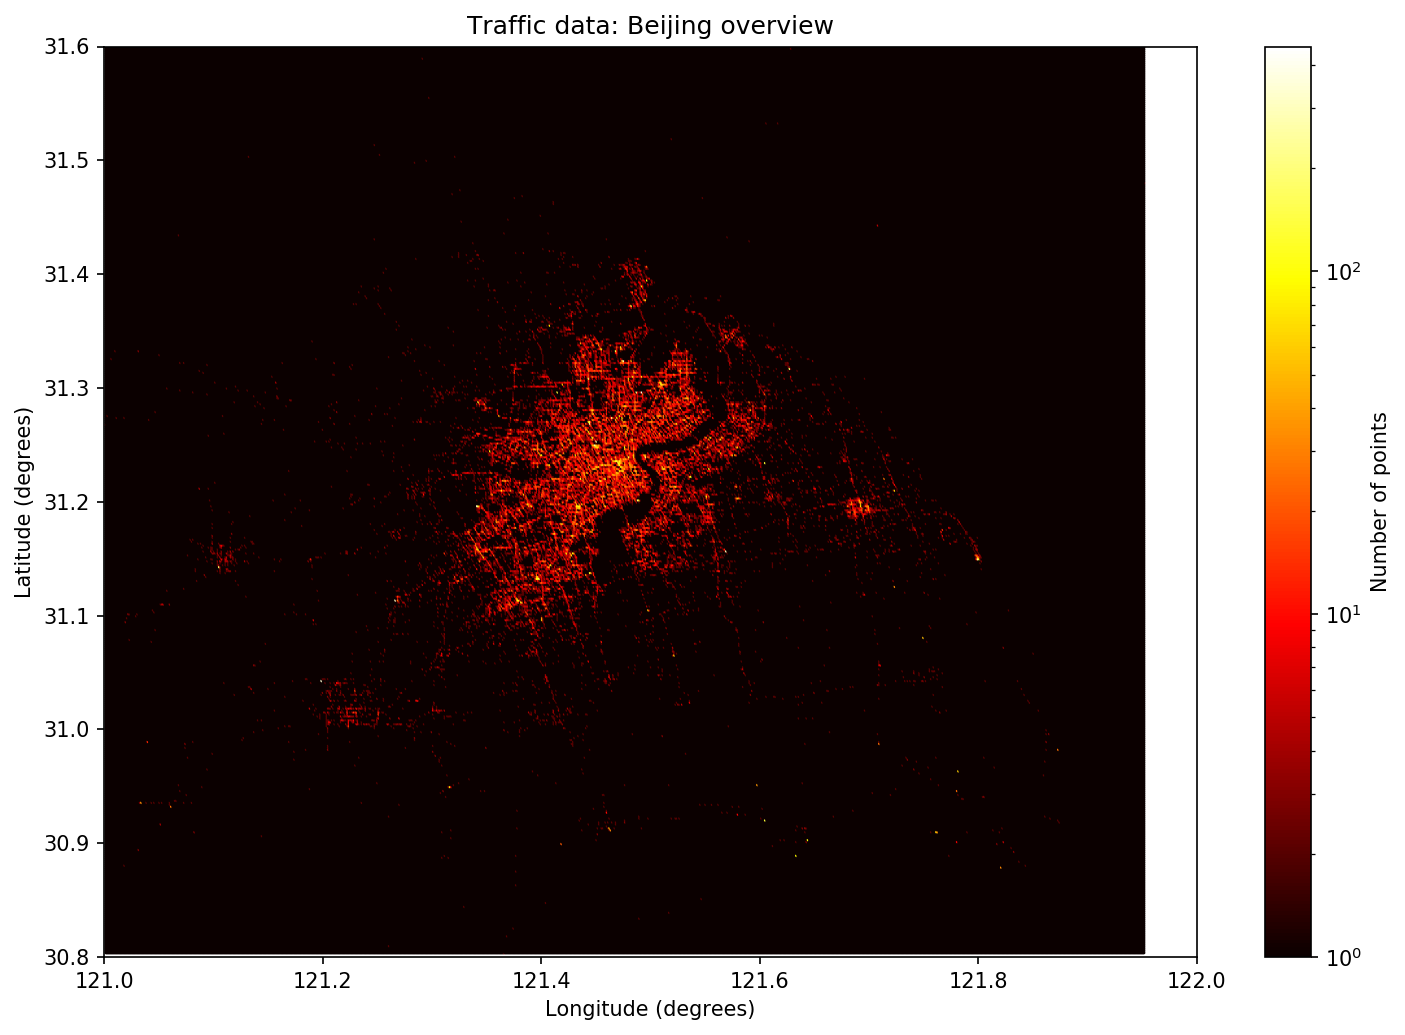

In [15]:
#%% Plot position density -- Overview 

print("Plotting position density...")
xmin, xmax = 121.0, 122.0
ymin, ymax = 30.8, 31.6

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data: Shanghai overview")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar()
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

In [17]:
# 也许是由于数据量太大，导致聚类失败，故只选择10辆出租车的数据进行尝试
data1=data
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sys
 
# represent GPS points as (lat, lon)
coords = data1.as_matrix(columns=['latitude', 'longitude'])
 
# earth's radius in km
kms_per_radian = 6371.0088
# define epsilon as 0.5 kilometers, converted to radians for use by haversine
epsilon = 0.5 / kms_per_radian
 
# eps is the max distance that points can be from each other to be considered in a cluster
# min_samples is the minimum cluster size (everything else is classified as noise)
db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters (ignore noisy samples which are given the label -1)
num_clusters = len(set(cluster_labels) - set([-1]))
 
print ('Clustered ' + str(len(data1)) + ' points to ' + str(num_clusters) + ' clusters')
 
# turn the clusters in to a pandas series
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters
 
 

C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Clustered 182795 points to 33 clusters


0     [[31.1537, 121.546267], [31.1536, 121.54585], ...
1     [[31.21535, 121.476733], [31.29085, 121.42905]...
2     [[31.3211, 121.3783], [31.3178, 121.3766], [31...
3     [[31.1505, 121.8008], [31.158567, 121.7987], [...
4     [[31.1943, 121.6861], [31.1938, 121.6863], [31...
5     [[31.2001, 121.6043], [31.201999999999998, 121...
6     [[31.3745, 121.4875], [31.3818, 121.4948], [31...
7     [[31.3993, 121.4811], [31.4093, 121.4765], [31...
8     [[31.1385, 121.3311], [31.1291, 121.3243], [31...
9     [[31.2341, 121.601], [31.237, 121.6058], [31.2...
10    [[31.199, 121.589], [31.1991, 121.5895], [31.1...
11    [[31.35235, 121.579667], [31.3473, 121.5645], ...
12    [[31.0261, 121.2893], [31.0258, 121.2876], [31...
13    [[31.017, 121.3016], [31.016, 121.3021], [31.0...
14    [[31.0121, 121.2511], [31.0121, 121.2511], [31...
15    [[31.0065, 121.2245], [31.0088, 121.2171], [31...
16    [[31.2875, 121.3498], [31.289, 121.3435], [31....
17    [[31.347267, 121.418483], [31.3561, 121.42

In [26]:
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
 
# get the centroid point for each cluster
centermost_points = clusters.map(get_centermost_point)
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
 

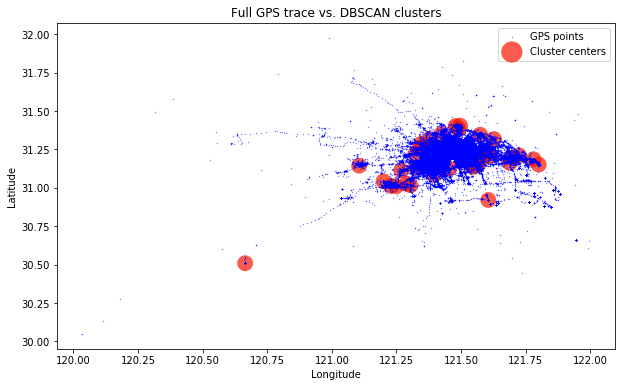

In [58]:
import matplotlib.pyplot as plt    # 注意，是matplotlib.pyplot,不然没有plt.subplots模块


fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lon'][0], rep_points['lat'][0], c='#fa1500', edgecolor='None', alpha=0.7, s=450)

for i in range(0,num_clusters):
    ax.scatter(rep_points['lon'][i], rep_points['lat'][i], c='#fa1500', edgecolor='None',alpha=0.7, s=250)

df_scatter = ax.scatter(data1['longitude'], data1['latitude'], c='b',alpha=0.7, s=0.1)  #alpha为透明度，s为点的大小

ax.set_title('Full GPS trace vs. DBSCAN clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['GPS points', 'Cluster centers'], loc='upper right')
 

 
plt.show()

In [61]:
#使用Python加载谷歌地图并可视化
import gmplot
gmap = gmplot.GoogleMapPlotter(rep_points['lat'][0], rep_points['lon'][0], 11)
#gmap.plot(data1.lat, data1.lon)
gmap.heatmap(rep_points['lat'][:num_clusters], rep_points['lon'][:num_clusters], radius=20)
gmap.draw("D:/study_by_YYC/study_2021_10/Taxi_HKUST/user_work_home.html")